In [5]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#caculate precision and recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

from aijack.attack.membership import ShadowMembershipInferenceAttack
from aijack.utils.utils import TorchClassifier, NumpyDataset

In [6]:

#load mnist dataset
from tensorflow.keras.datasets import mnist
#import shuffle from sklearn
from sklearn.utils import shuffle
#one hot encode from sklearn
from sklearn.preprocessing import OneHotEncoder



np.random.seed(42)
torch.manual_seed(42)



(X_train, y_train), (X_test, y_test) = mnist.load_data()

#shuffle the dataset
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# downsample X_train and y_train to 1000 samples
X_train = X_train[:1000]
y_train = y_train[:1000]

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
# reshaping data
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#normalizing data
X_train /= 255
X_test /= 255

#splitting train dataset into train and shadow dataset
X_train, X_shadow, y_train, y_shadow = train_test_split(
    X_train, y_train, test_size=1 / 2, random_state=42
)





# downsample X_test and y_test to 100 samples
X_test = X_test[:100]
y_test = y_test[:100]

#converting labels to int64
y_train = y_train.astype(np.long)
y_test = y_test.astype(np.long)
y_shadow = y_shadow.astype(np.long)


# We simulate the situation where the distribution of training dataset is different from the test/shadow datasets.
X_test = 0.5 * X_test + 0.5 * np.random.normal(size=(X_test.shape))
X_test=X_test.astype(np.float32)



/tmp/ipykernel_1440/3541508647.py:49: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = y_train.astype(np.long)
/tmp/ipykernel_1440/3541508647.py:50: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.com

# PYTORCH VARIATION

Observe variation of attack metrics over complexity of model

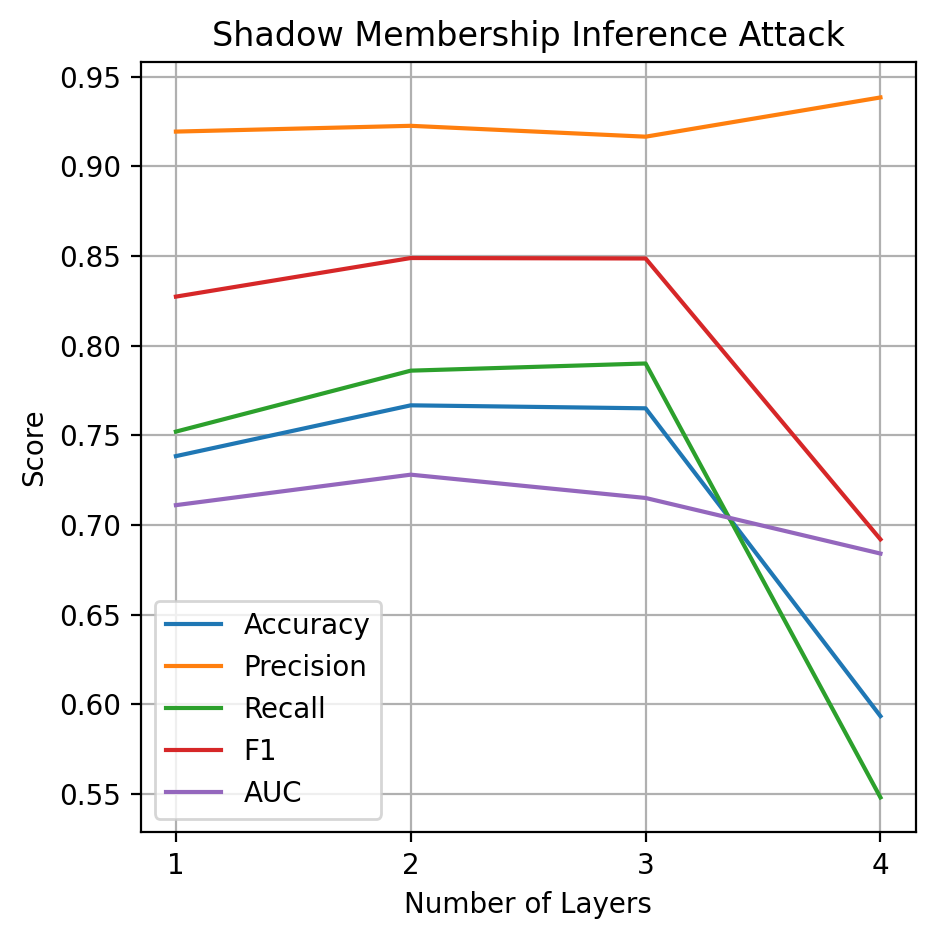

In [7]:
total_trys=4
attack_acc=[]
attack_prec=[]
attack_rec=[]
attack_f1=[]
attack_auc=[]



for indexer in range(total_trys):
    # Train the victim
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    if indexer==0:
        class LM(nn.Module):
            def __init__(self):
                super(LM, self).__init__()
                self.lin1 = nn.Linear(28 * 28, 10)

            def forward(self, x):
                out = self.lin1(x)
                return out
            
    if indexer==1:
        class LM(nn.Module):
            def __init__(self):
                super(LM, self).__init__()
                self.lin1 = nn.Linear(28 * 28, 100)
                self.lin2 = nn.Linear(100, 10)

            def forward(self, x):
                out = self.lin1(x)
                out = self.lin2(out)
                return out
            
    if indexer==2:
        class LM(nn.Module):
            def __init__(self):
                super(LM, self).__init__()
                self.lin1 = nn.Linear(28 * 28, 100)
                self.lin2 = nn.Linear(100, 50)
                self.lin3 = nn.Linear(50, 10)

            def forward(self, x):
                out = self.lin1(x)
                out = self.lin2(out)
                out = self.lin3(out)
                return out
            
    if indexer==3:
        class LM(nn.Module):
            def __init__(self):
                super(LM, self).__init__()
                self.lin1 = nn.Linear(28 * 28, 100)
                self.lin2 = nn.Linear(100, 50)
                self.lin3 = nn.Linear(50, 25)
                self.lin4 = nn.Linear(25, 10)

            def forward(self, x):
                out = self.lin1(x)
                out = self.lin2(out)
                out = self.lin3(out)
                out = self.lin4(out)
                return out
            
    

   # Train the victim
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    criterion = nn.CrossEntropyLoss()
    net = LM().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    # You need to wrap the torch module with TorchClassifier
    clf = TorchClassifier(
        net, criterion, optimizer, batch_size=64, epoch=100, device=device
    )

    clf.fit(X_train, y_train),clf.score(X_test, y_test)


    # Train the attacker
    def create_clf():
        _net = LM().to(device)
        _optimizer = optim.Adam(_net.parameters(), lr=0.001)
        return TorchClassifier(
            _net, criterion, _optimizer, batch_size=64, epoch=100, device=device
        )


    shadow_models = [create_clf() for _ in range(2)]
    attack_models = [SVC(probability=True) for _ in range(10)]

    attacker = ShadowMembershipInferenceAttack(clf, shadow_models, attack_models)
    attacker.fit(X_shadow, y_shadow)


    # Documenting Attack scores of membership inference
    in_result = attacker.predict(clf.predict_proba(X_train), y_train)
    out_result = attacker.predict(clf.predict_proba(X_test), y_test)

    in_label = np.ones(in_result.shape[0])
    out_label = np.zeros(out_result.shape[0])
    
    att_acc=accuracy_score(
        np.concatenate([in_label, out_label]), np.concatenate([in_result, out_result])
    )


    att_pr=precision_score(
        np.concatenate([in_label, out_label]), np.concatenate([in_result, out_result])
    )

    att_r=recall_score(
        np.concatenate([in_label, out_label]), np.concatenate([in_result, out_result])
    )

    att_f1=f1_score(
        np.concatenate([in_label, out_label]), np.concatenate([in_result, out_result])
    )
    
    att_auc=roc_auc_score(
        np.concatenate([in_label, out_label]), np.concatenate([in_result, out_result])
    )

    attack_acc.append(att_acc)
    attack_prec.append(att_pr)
    attack_rec.append(att_r)
    attack_f1.append(att_f1)
    attack_auc.append(att_auc)



#plotting the results
plt.figure(figsize=(5,5),dpi=200)
plt.plot(attack_acc, label='Accuracy')
plt.plot(attack_prec, label='Precision')
plt.plot(attack_rec, label='Recall')
plt.plot(attack_f1, label='F1')
plt.plot(attack_auc, label='AUC')
plt.xlabel('Number of Layers')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.xticks([0,1,2,3],['1','2','3','4'])
plt.title('Shadow Membership Inference Attack')
plt.show()




In [8]:
print("Accuracy: ",att_acc)
print("Precision: ",att_pr)
print("Recall: ",att_r)
print("F1: ",att_f1)
print("AUC: ",att_auc)

Accuracy:  0.5933333333333334
Precision:  0.9383561643835616
Recall:  0.548
F1:  0.6919191919191918
AUC:  0.684
